In [0]:
import os
import sys
import tarfile
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display, Image, HTML
import h5py
import urllib.request
plt.rcParams['figure.figsize'] = (16.0, 4.0)
%matplotlib inline

In [4]:
#https://github.com/thomalm/svhn-multi-digit/blob/master/05-svhn-multi-preprocessing.ipynb

urllib.request.urlretrieve("http://ufldl.stanford.edu/housenumbers/train.tar.gz", "train.tar.gz")
urllib.request.urlretrieve("http://ufldl.stanford.edu/housenumbers/test.tar.gz", "test.tar.gz")
urllib.request.urlretrieve("http://ufldl.stanford.edu/housenumbers/extra.tar.gz", "extra.tar.gz")

('extra.tar.gz', <http.client.HTTPMessage at 0x7fa9e146b048>)

In [5]:
#https://github.com/thomalm/svhn-multi-digit/blob/master/05-svhn-multi-preprocessing.ipynb
def extract_tarball(filename, force=False):
    """ Helper function for extracting tarball files
    """
    # Drop the file extension
    root = filename.split('.')[0] 
    
    # If file is already extracted - return
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
        return
    
    # If file is a tarball file - extract it
    if (filename.endswith("tar.gz")):
        print("Extracting %s ..." % filename)
        tar = tarfile.open(filename, "r:gz")
        tar.extractall()
        tar.close()
        
      

# Extract the tarballs
extract_tarball('test.tar.gz')
extract_tarball('train.tar.gz')
extract_tarball('extra.tar.gz')

test already present - Skipping extraction of test.tar.gz.
train already present - Skipping extraction of train.tar.gz.
extra already present - Skipping extraction of extra.tar.gz.


In [0]:

#https://github.com/thomalm/svhn-multi-digit/blob/master/unpacker.py
#reposted python file helper function directly into code 
class DigitStructWrapper:
    """
    Wrapper for the H5PY digitStruct files from the SVHN dataset
    Creates an array of dictionaries containing the filename and bounding boxes for every digit in the image.
    Adapted from https://github.com/hangyao
    """

    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def get_name(self, n):
        """Return the name of the n(th) digit struct"""
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def get_attribute(self, attr):
        """Helper function for dealing with one vs. multiple bounding boxes"""
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def get_bbox(self, n):
        """Return a dict containing the data from the n(th) bbox"""
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.get_attribute(self.inf[bb]["height"])
        bbox['label'] = self.get_attribute(self.inf[bb]["label"])
        bbox['left'] = self.get_attribute(self.inf[bb]["left"])
        bbox['top'] = self.get_attribute(self.inf[bb]["top"])
        bbox['width'] = self.get_attribute(self.inf[bb]["width"])
        return bbox

    def get_item(self, n):
        """Return the name and bounding boxes of a single image"""
        s = self.get_bbox(n)
        s['name'] = self.get_name(n)
        return s

    def unpack(self):
        """Returns a list of dicts containing all the bounding boxes"""
        return [self.get_item(i) for i in range(len(self.digitStructName))]

    def unpack_all(self):
        pictDat = self.unpack()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = {'filename': pictDat[i]["name"]}
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label'] = pictDat[i]['label'][j]
                figure['left'] = pictDat[i]['left'][j]
                figure['top'] = pictDat[i]['top'][j]
                figure['width'] = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [0]:
#unpack the bounding boxes 
train_bbox =DigitStructWrapper('train/digitStruct.mat').unpack_all()
test_bbox = DigitStructWrapper('test/digitStruct.mat').unpack_all()
extra_bbox = DigitStructWrapper('extra/digitStruct.mat').unpack_all()

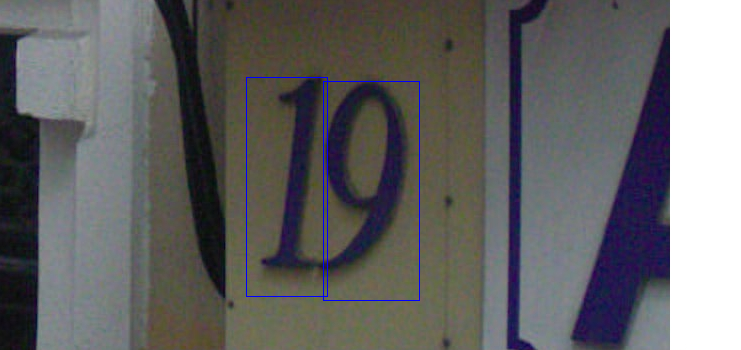

In [8]:
#still using https://github.com/thomalm/svhn-multi-digit/blob/master/05-svhn-multi-preprocessing.ipynb
#to visualize the bounding boxes
from PIL import Image, ImageDraw

def display_bounding_boxes(img, bounding_boxes):
    """Displays an image and overlays the bounding boxes
    """
    # Opens and identifies the given image file
    image = Image.open(img)
    
    # Use draw module can be used to annotate the image
    draw = ImageDraw.Draw(image)
    
    for b in bounding_boxes:
        
        # Bounding box rectangle [x0, y0, x1, y1]
        rectangle = [b['left'], b['top'], b['left'] + b['width'], b['top'] + b['height']]
        
        # Draw a rectangle on top of the image
        draw.rectangle(rectangle, outline="blue")
        
    # Return altered image    
    return image


# Select an image and the corresponding boxes
image = 'train/1.png'
image_bounding_boxes = train_bbox[0]['boxes']
     
# Display image with bounding boxes
display_bounding_boxes(image, image_bounding_boxes)

In [9]:
#another helper function to transform the dictionary to df 
#https://github.com/thomalm/svhn-multi-digit/blob/master/05-svhn-multi-preprocessing.ipynb
#adapt for collab 
def dict_to_dataframe(image_bounding_boxes, path):
    """ Helper function for flattening the bounding box dictionary
    """
    # Store each bounding box
    boxes = []
    
    # For each set of bounding boxes
    for image in image_bounding_boxes:
        
        # For every bounding box
        for bbox in image['boxes']:
            
            # Store a dict with the file and bounding box info
            boxes.append({
                    'filename': path + image['filename'],
                    'label': bbox['label'],
                    'width': bbox['width'],
                    'height': bbox['height'],
                    'top': bbox['top'],
                    'left': bbox['left']})
            
    # return the data as a DataFrame
    return pd.DataFrame(boxes)


# We store the bounding boxes here
bbox_file = 'bounding_boxes.csv'

if not os.path.isfile(bbox_file):
    
    # Extract every individual bounding box as DataFrame  
    train_df = dict_to_dataframe(train_bbox, 'train/')
    test_df = dict_to_dataframe(test_bbox, 'test/')
    extra_df = dict_to_dataframe(test_bbox, 'extra/')
    

    print("Training", train_df.shape)
    print("Test", test_df.shape)
    print('')

    # Concatenate all the information in a single file
    df = pd.concat([train_df, test_df, extra_df])
    
    print("Combined", df.shape)

    # Write dataframe to csv
    df.to_csv(bbox_file, index=False)

    # Delete the old dataframes
    del train_df, test_df, train_bbox, test_bbox, extra_df, extra_bbox
    
else:
    # Load preprocessed bounding boxes
    df = pd.read_csv(bbox_file)

# Display the first 10 rows of dataframe
df.head()

,filename,label,width,height,top,left
0,train/1.png,1.0,81.0,219.0,77.0,246.0
1,train/1.png,9.0,96.0,219.0,81.0,323.0
2,train/2.png,2.0,23.0,32.0,29.0,77.0
3,train/2.png,3.0,26.0,32.0,25.0,98.0
4,train/3.png,2.0,8.0,15.0,5.0,17.0


In [10]:
#combine the labels 
# Rename the columns to more suitable names
df.rename(columns={'left': 'x0', 'top': 'y0'}, inplace=True)

# Calculate x1 and y1
df['x1'] = df['x0'] + df['width']
df['y1'] = df['y0'] + df['height']

# Perform the following aggregations
aggregate = {'x0':'min',
             'y0':'min',
             'x1':'max',
             'y1':'max',
             'label':{
                'labels': lambda x: list(x),
                'num_digits': 'count'}}

# Apply the aggration
df = df.groupby('filename').agg(aggregate).reset_index()

# Fix the column names after aggregation
df.columns = [x[0] if i < 5 else x[1] for i, x in enumerate(df.columns.values)]

# Display the results
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,filename,x0,y0,x1,y1,labels,num_digits
0,extra/1.png,43.0,7.0,62.0,37.0,[5.0],1
1,extra/10.png,16.0,19.0,38.0,40.0,"[1.0, 6.0]",2
2,extra/100.png,124.0,65.0,152.0,99.0,"[6.0, 1.0]",2
3,extra/1000.png,210.0,59.0,245.0,87.0,"[2.0, 7.0]",2
4,extra/10000.png,35.0,11.0,66.0,32.0,"[1.0, 4.0, 3.0]",3


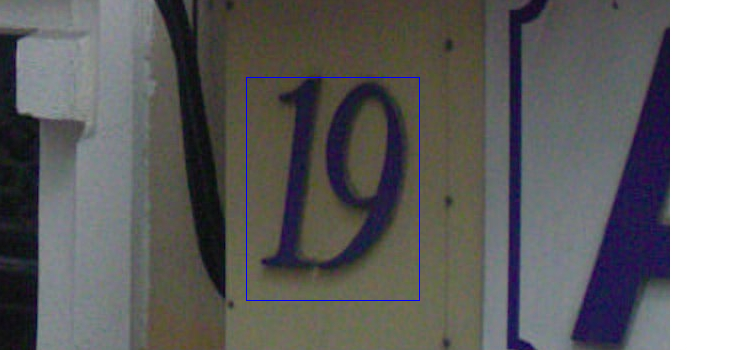

In [11]:
from PIL import Image, ImageDraw
#https://github.com/thomalm/svhn-multi-digit/blob/master/05-svhn-multi-preprocessing.ipynb
def display_bbox(image_path, bbox):
    """ Helper function to display a single image and bounding box
    """
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    draw.rectangle([bbox['x0'], bbox['y0'], bbox['x1'], bbox['y1']], outline="blue")
    return image


# Select a image and bounding box
image = 'train/1.png'
bbox = df[df.filename == image]

# Display image
display_bbox(image, bbox)

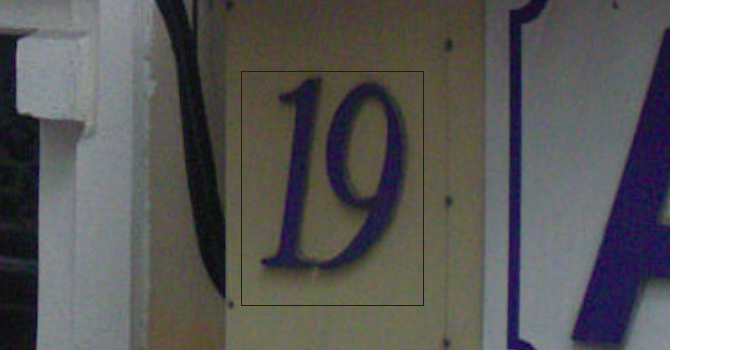

In [12]:
#Thomas expanded his by 30% but I want to keep our boxes really tight, so we dont include other obstructions 
# Calculate the increase in both directions

#only increase by 5%
df['x_increase'] = ((df['x1'] - df['x0']) * 0.05) / 2.
df['y_increase'] = ((df['y1'] - df['y0']) * 0.05) / 2.

# Apply the increase in all four directions
df['x0'] = (df['x0'] - df['x_increase']).astype('int')
df['y0'] = (df['y0'] - df['y_increase']).astype('int')
df['x1'] = (df['x1'] + df['x_increase']).astype('int')
df['y1'] = (df['y1'] + df['y_increase']).astype('int')


# Select the dataframe row corresponding to our image
image = 'train/1.png'
bbox = df[df.filename == image]

# Display image
display_bbox(image, bbox)

In [13]:
#https://github.com/thomalm/svhn-multi-digit/blob/master/05-svhn-multi-preprocessing.ipynb
#adapt for collab 
def get_image_size(filepath):
    """Returns the image size in pixels given as a 2-tuple (width, height)
    """
    image = Image.open(filepath)
    return image.size 

def get_image_sizes(folder):
    """Returns a DataFrame with the file name and size of all images contained in a folder
    """
    image_sizes = []
    
    # Get all .png images contained in the folder
    images = [img for img in os.listdir(folder) if img.endswith('.png')]
    
    # Get image size of every individual image
    for image in images:
        w, h = get_image_size(folder + image)
        image_size = {'filename': folder + image, 'image_width': w, 'image_height': h}
        image_sizes.append(image_size)
        
    # Return results as a pandas DataFrame
    return pd.DataFrame(image_sizes)


# Extract the image sizes
train_sizes = get_image_sizes('train/')
test_sizes = get_image_sizes('test/')
extra_sizes = get_image_sizes('test/')

# Concatenate all the information in a single file
image_sizes = pd.concat([train_sizes, test_sizes, extra_sizes])

# Delete old dataframes
del train_sizes, test_sizes, extra_sizes

# Display 10 image sizes
image_sizes.head(10)

,filename,image_width,image_height
0,train/30773.png,106,43
1,train/3037.png,70,33
2,train/26021.png,65,34
3,train/23489.png,172,77
4,train/13917.png,182,84
5,train/31724.png,39,21
6,train/6012.png,83,45
7,train/5607.png,204,89
8,train/22323.png,84,42
9,train/31783.png,113,56


In [14]:
#https://github.com/thomalm/svhn-multi-digit/blob/master/05-svhn-multi-preprocessing.ipynb
print("Bounding boxes", df.shape)
print("Image sizes", image_sizes.shape)
print('')

# Inner join the datasets on filename
df = pd.merge(df, image_sizes, on='filename', how='inner')

print("Combined", df.shape)

# Delete the image size df
#del image_sizes

# Store checkpoint
df.to_csv("image_data.csv", index=False)
df = pd.read_csv('image_data.csv')

df.head()

Bounding boxes (59538, 9)
Image sizes (59538, 3)

Combined (59538, 11)


,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,image_width,image_height
0,test/1.png,42,6,62,37,[5.0],1,0.475,0.750,99,47
1,test/1.png,42,6,62,37,[5.0],1,0.475,0.750,99,47
2,test/10.png,15,18,38,40,"[1.0, 6.0]",2,0.550,0.525,87,55
3,test/10.png,15,18,38,40,"[1.0, 6.0]",2,0.550,0.525,87,55
4,test/100.png,123,64,152,99,"[6.0, 1.0]",2,0.700,0.850,353,133


In [15]:
#remove the bad datapoints
# Correct bounding boxes not contained by image
df.loc[df['x0'] < 0, 'x0'] = 0
df.loc[df['y0'] < 0, 'y0'] = 0
df.loc[df['x1'] > df['image_width'], 'x1'] = df['image_width']
df.loc[df['y1'] > df['image_height'], 'y1'] = df['image_width']

df.head()

,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,image_width,image_height
0,test/1.png,42,6,62,37,[5.0],1,0.475,0.750,99,47
1,test/1.png,42,6,62,37,[5.0],1,0.475,0.750,99,47
2,test/10.png,15,18,38,40,"[1.0, 6.0]",2,0.550,0.525,87,55
3,test/10.png,15,18,38,40,"[1.0, 6.0]",2,0.550,0.525,87,55
4,test/100.png,123,64,152,99,"[6.0, 1.0]",2,0.700,0.850,353,133


In [0]:
#there's only one image with more than 5 numbers, remove it from the set 
# Count the number of images by number of digits
df.num_digits.value_counts(sort=False)
df = df[df.num_digits < 6]

In [17]:
df[['image_width', 'image_height']].describe().round(decimals=2)

,image_width,image_height
count,59537.00,59537.00
mean,147.73,63.51
std,103.53,44.80
min,25.00,12.00
25%,81.00,35.00
50%,116.00,49.00
75%,179.00,76.00
max,1083.00,516.00


In [0]:
#https://github.com/thomalm/svhn-multi-digit/blob/master/05-svhn-multi-preprocessing.ipynb
from skimage import transform
#from scipy.ndimage import imread
#from scipy.misc import imresize
import imageio

def crop_and_resize(image, img_size):
    """ Crop and resize an image
    """
    image_data = imageio.imread(image['filename'])
    crop = image_data[image['y0']:image['y1'], image['x0']:image['x1'], :]
    return transform.resize(crop, img_size)


In [0]:
#adapted due to tuple /datatype issues 
#https://github.com/thomalm/svhn-multi-digit/blob/master/05-svhn-multi-preprocessing.ipynb
def create_dataset(df, img_size):
    """ Helper function for converting images into a numpy array
    """
    # Initialize the numpy arrays (0's are stored as 10's)
    X = np.zeros(shape=(df.shape[0], img_size[0], img_size[0], 3), dtype=float)
    y = np.full((df.shape[0], 5), 10, dtype=float)
    
    # Iterate over all images in the pandas dataframe (slow!)
    for i, (index, image) in enumerate(df.iterrows()):
        
        # Get the image data
        X[i] = crop_and_resize(image, img_size)
        
    lab = []
#split/clean/append the labels for each image 
    for i, (index, image) in enumerate(df.iterrows()):
      labels_1 = ((image['labels']))
      labels_1 = labels_1.replace('10.0', '0.0')
      labels_1 = ((labels_1.replace('[','')).replace(']','')).replace(',','').split()
      lab.append((labels_1))

      y[i,0:(np.array((lab)[i]).shape[0])] = ((np.array(lab))[i])
    return X, y

image_size = (32, 32)

# Get cropped images and labels 
X_train, y_train = create_dataset(df[df.filename.str.contains('train')], image_size)
X_test, y_test = create_dataset(df[df.filename.str.contains('test')], image_size)
X_extra, y_extra = create_dataset(df[df.filename.str.contains('extra')], image_size)

In [0]:
#cast both train and test as ints for more intuitive labeling 
y_train=y_train.astype(int)
y_test=y_test.astype(int)
y_extra=y_extra.astype(int)



In [21]:
print("Training", X_train.shape, y_train.shape)

Training (33401, 32, 32, 3) (33401, 5)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[ 1  9 10 10 10]')

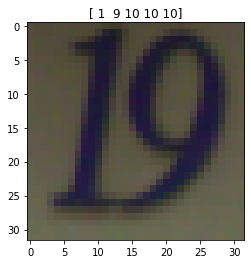

In [22]:
# Plot a cropped image
plt.imshow(X_train[0])
plt.title(y_train[0])
#note: 10 is null, 10 just means nothing is there 


In [0]:
#https://github.com/thomalm/svhn-multi-digit/blob/master/05-svhn-multi-preprocessing.ipynb
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Helper function for plotting nrows * ncols images
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted label
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number)  
        ax.imshow(images[i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

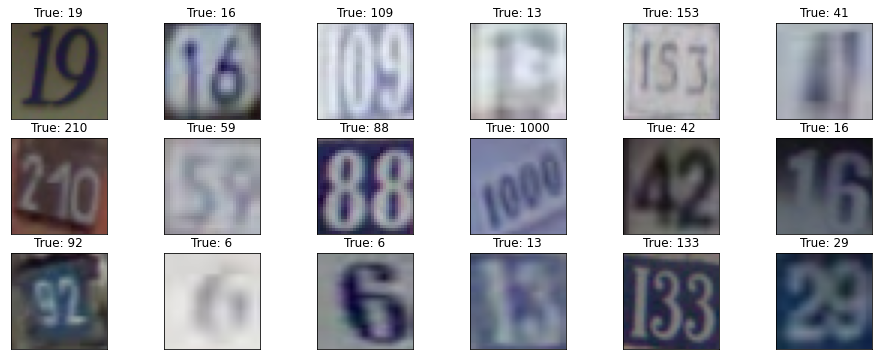

In [24]:
# Display images from the training set
plot_images(X_train, 3, 6, y_train);

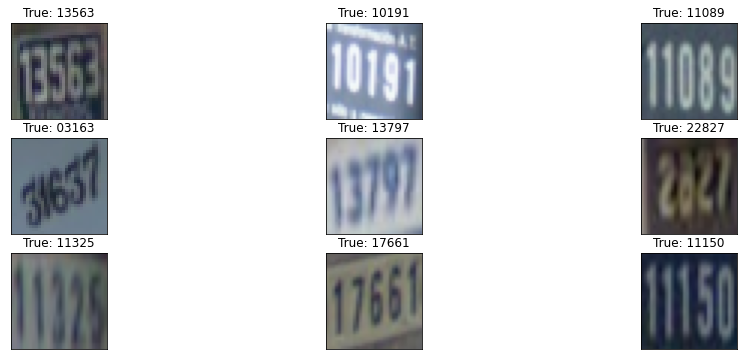

In [25]:
#plot some 5 digit samples from training set (this is our highest amount of digits)
# Find some images with five digits
five_digits = (y_train != 10).sum(1) == 5

# Display some examples 
plot_images(X_train[five_digits], 3,3, y_train[five_digits]);

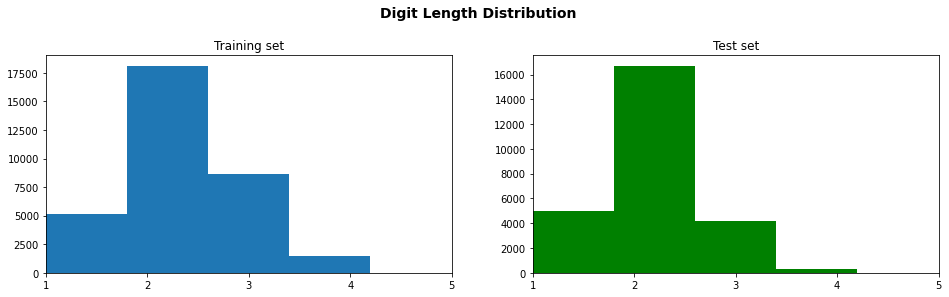

In [26]:
#set the axis ticks to ints only 
from matplotlib.ticker import MaxNLocator
#https://stackoverflow.com/questions/12050393/how-to-force-the-y-axis-to-only-use-integers-in-matplotlib

#plot distributions of the training vs test set
# Initialize the subplotgrid
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(16, 4))

# Set the main figure title
fig.suptitle('Digit Length Distribution', fontsize=14, fontweight='bold', y=1.05)

# Sequence length distribution - training set 
ax1.hist((y_train != 10).sum(1), bins=5)
ax1.set_title("Training set");
ax1.set_xlim(1,5)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Sequence length distribution - test set 
ax2.hist((y_test != 10).sum(1), bins=5, color='g')
ax2.set_title("Test set");

In [0]:
#convert to greyscale
#https://github.com/thomalm/svhn-multi-digit/blob/master/05-svhn-multi-preprocessing.ipynb
def rgb2gray(images):
    """Convert images from rbg to grayscale
    """
    greyscale = np.dot(images, [0.2989, 0.5870, 0.1140])
    return np.expand_dims(greyscale, axis=3)

# Transform the images to greyscale
X_train = rgb2gray(X_train).astype(np.float32)
X_test = rgb2gray(X_test).astype(np.float32)


In [0]:
x_train_d2.shape

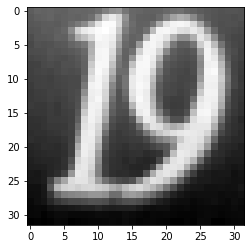

In [28]:
#convert to three dim 
nsamples, nx, ny, nz = X_train.shape
x_train_d2 = X_train.reshape((nsamples,nx,ny*nz))

nsamples_test, nx_test, ny_test, nz_test = X_test.shape
x_test_d2 =  X_test.reshape((nsamples_test,nx_test*ny_test*nz_test))

x_train_d2[0].shape
plt.imshow(x_train_d2[0], cmap=plt.cm.binary)

In [29]:
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (33401, 32, 32, 1)
y_train shape: (33401, 5)


In [0]:
#to get the number for the final dense layer
#len(np.vstack(set(map(tuple, y_train))))

In [31]:
#https://colab.research.google.com/github/ozanpekmezci/capstone/blob/master/multi_digit_recognition_svhn.ipynb#scrollTo=_QUuHcyyF5iq
# Converting labels to One-hot representations of shape (set_size, digits, classes)
#11 possible classes, 0 - 10 
from keras.utils import np_utils
def convert_labels(labels):
    
    # As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    # Each digit array will be of shape (60000,11)
        
    # Declare output ndarrays
    # 5 for digits, 11 for possible classes  
    dig0_arr = np.ndarray(shape=(len(labels),11))
    dig1_arr = np.ndarray(shape=(len(labels),11))
    dig2_arr = np.ndarray(shape=(len(labels),11))
    dig3_arr = np.ndarray(shape=(len(labels),11))
    dig4_arr = np.ndarray(shape=(len(labels),11))
    
    for index,label in enumerate(labels):
        
        # Using np_utils from keras to OHE the labels in the image
        dig0_arr[index,:] = np_utils.to_categorical(label[0],11)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],11)
        dig2_arr[index,:] = np_utils.to_categorical(label[2],11)
        dig3_arr[index,:] = np_utils.to_categorical(label[3],11)
        dig4_arr[index,:] = np_utils.to_categorical(label[4],11)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

Using TensorFlow backend.


In [0]:
train_labels = convert_labels(y_train)
test_labels = convert_labels(y_test)

In [35]:
np.shape(train_labels)

(5, 33401, 11)

In [44]:
#https://colab.research.google.com/github/ozanpekmezci/capstone/blob/master/multi_digit_recognition_svhn.ipynb#scrollTo=ixTneFcAM_BN
# Building the model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adadelta, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard#
# number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# defining the input
inputs = Input(shape=(32,32,1))

# Model taken from keras example.

cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(inputs)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
#cov = Dense(512)
cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Dropout(0.3)(cov)


cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)

cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)


cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)


cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(2056, activation='relu')(cov_out)
cov2 = Dropout(0.3)(cov2)

# Prediction layers
c0 = Dense(11, activation='softmax')(cov2)
c1 = Dense(11, activation='softmax')(cov2)
c2 = Dense(11, activation='softmax')(cov2)
c3 = Dense(11, activation='softmax')(cov2)
c4 = Dense(11, activation='softmax')(cov2)

# Defining the model
model = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])
print (model.summary())



Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 32)   288         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 32)   128         conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 32, 32, 32)   0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [58]:
model.metrics_names

['loss',
 'dense_14_loss',
 'dense_15_loss',
 'dense_16_loss',
 'dense_17_loss',
 'dense_18_loss',
 'dense_14_acc',
 'dense_15_acc',
 'dense_16_acc',
 'dense_17_acc',
 'dense_18_acc']

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='nadam')

In [138]:
# training the model and saving metrics in history
history = model.fit(X_train,train_labels,batch_size=30,epochs=30,verbose=2, validation_data=(X_test, test_labels))

Train on 33401 samples, validate on 26136 samples
Epoch 1/30
 - 25s - loss: 0.3964 - dense_14_loss: 0.1345 - dense_15_loss: 0.1440 - dense_16_loss: 0.0916 - dense_17_loss: 0.0260 - dense_18_loss: 2.6624e-04 - dense_14_acc: 0.9556 - dense_15_acc: 0.9550 - dense_16_acc: 0.9711 - dense_17_acc: 0.9919 - dense_18_acc: 0.9999 - val_loss: 0.7174 - val_dense_14_loss: 0.2641 - val_dense_15_loss: 0.2910 - val_dense_16_loss: 0.1377 - val_dense_17_loss: 0.0229 - val_dense_18_loss: 0.0017 - val_dense_14_acc: 0.9368 - val_dense_15_acc: 0.9314 - val_dense_16_acc: 0.9674 - val_dense_17_acc: 0.9945 - val_dense_18_acc: 0.9998
Epoch 2/30
 - 25s - loss: 0.3998 - dense_14_loss: 0.1423 - dense_15_loss: 0.1416 - dense_16_loss: 0.0906 - dense_17_loss: 0.0250 - dense_18_loss: 2.7655e-04 - dense_14_acc: 0.9547 - dense_15_acc: 0.9550 - dense_16_acc: 0.9709 - dense_17_acc: 0.9914 - dense_18_acc: 0.9999 - val_loss: 0.7239 - val_dense_14_loss: 0.2618 - val_dense_15_loss: 0.2953 - val_dense_16_loss: 0.1409 - val_den

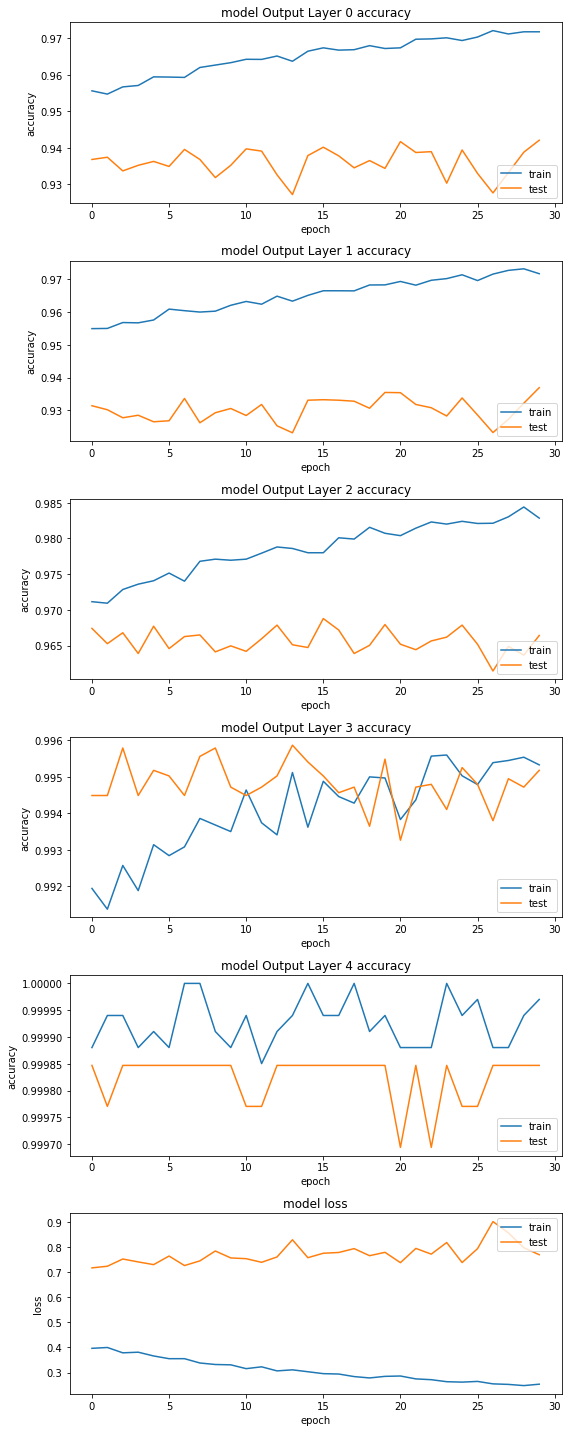

In [139]:

# plotting the metrics
fig = plt.figure(figsize=(8,20))
plt.subplots_adjust(hspace=.01, wspace=.01)
plt.subplot(6,1,1)
plt.plot(history.history['dense_14_acc'])
plt.plot(history.history['val_dense_14_acc'])
plt.title('model Output Layer 0 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
#plt.show ()
plt.subplot(6,1,2)
plt.plot(history.history['dense_15_acc'])
plt.plot(history.history['val_dense_15_acc'])
plt.title('model Output Layer 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(6,1,3)
plt.plot(history.history['dense_16_acc'])
plt.plot(history.history['val_dense_16_acc'])
plt.title('model Output Layer 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(6,1,4)
plt.plot(history.history['dense_17_acc'])
plt.plot(history.history['val_dense_17_acc'])
plt.title('model Output Layer 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(6,1,5)
plt.plot(history.history['dense_18_acc'])
plt.plot(history.history['val_dense_18_acc'])
plt.title('model Output Layer 4 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(6,1,6)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

#plt.subplots_adjust(hspace=.1)
#plt.show()
plt.tight_layout()



In [0]:
predictions = model.predict(X_test)

In [0]:
#https://colab.research.google.com/github/ozanpekmezci/capstone/blob/master/multi_digit_recognition_svhn.ipynb#scrollTo=w1gl0EeoPo6k
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
   # coverage_counter = 0
    confidence = 0.7
    for i in range(0,len(predictions[0])):
        # Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter += 1
           # if predictions[j][i][np.argmax(predictions[j][i])] >= confidence:
                #coverage_counter += 1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter / float(len(predictions[0]) * 5)
    global_accuracy = global_sequence_counter / float(len(predictions[0]))
   # coverage = coverage_counter / float(len(predictions[0]) * 5)
    
    return ind_accuracy,global_accuracy#, coverage

In [0]:
ind_acc, glob_acc = calculate_acc(predictions, test_labels)

In [143]:
print("The individual accuracy is {} %".format(ind_acc * 100))
print("The sequence prediction accuracy is {} %".format(glob_acc * 100))
#print("The coverage is {} %".format(coverage * 100))

The individual accuracy is 96.80899908172636 %
The sequence prediction accuracy is 87.74104683195593 %


In [144]:
nsamples_test, nx_test, ny_test, nz_test = X_test.shape
x_test_d3 = X_test.reshape((nsamples_test,nx_test,ny_test*nz_test))
x_test_d2.shape

(26136, 32, 32)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[ 2  1  0 10 10]')

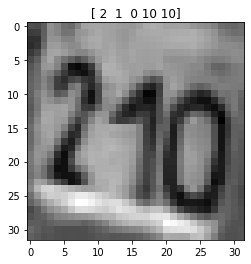

In [145]:
#convert to three dim 
nsamples, nx, ny, nz = X_train.shape
x_train_d2 = X_train.reshape((nsamples,nx,ny*nz))

nsamples_test, nx_test, ny_test, nz_test = X_test.shape
x_test_d2 =  X_test.reshape((nsamples_test,nx_test,ny_test*nz_test))

x_train_d2[0].shape
#plot an example 
plt.imshow(x_train_d2[6], cmap=plt.cm.binary)
plt.title(y_train[6])


In [146]:
#for cleaner labels for graphing , flatten the arrays into a single array 
flattened_y_test=[]

for i in range(0, len(predictions[0])):
  test_helper=[]
  for j in range(0,5):
 # actual_labels.append(np.argmax(test_labels[j][i]))
    test_helper.append(np.argmax(predictions[j][i]))
  flattened_y_test.append(test_helper)

#look at a small sample
flattened_y_test[:10]

[[5, 10, 10, 10, 10],
 [5, 10, 10, 10, 10],
 [1, 6, 10, 10, 10],
 [1, 6, 10, 10, 10],
 [6, 1, 10, 10, 10],
 [6, 1, 10, 10, 10],
 [2, 7, 1, 10, 10],
 [2, 7, 1, 10, 10],
 [1, 4, 3, 10, 10],
 [1, 4, 3, 10, 10]]

In [147]:
print((predictions[0][0]))

[4.0317340e-28 6.0349568e-16 3.3901320e-19 2.4783979e-14 5.9044857e-20
 1.0000000e+00 9.3591085e-13 4.2907963e-19 1.0313320e-19 9.2839182e-21
 1.6821927e-33]


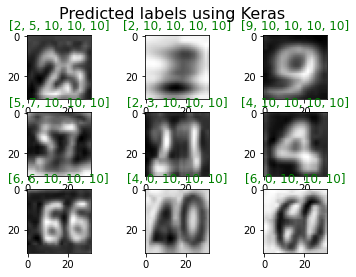

In [148]:
#plot a random sample w/ actual labels + pred labels 
import random
rand_pred = [random.randint(0, len(predictions[0])) for i in range(9)]

rand_pred
#plot the randomized predictions 
fig, axs = plt.subplots(3, 3)
fig.suptitle('Predicted labels using Keras', fontsize=16)
for i, j in zip((rand_pred), axs.flat):
  j.imshow(x_test_d2[i], cmap=plt.cm.binary)
  #j.set_title(y_test[i])
  #j.set_title(predictions[i])
  #j.set_title(flattened_y_test[i])
  j.set_title(flattened_y_test[i], color = ('red' if np.all(flattened_y_test[i])!=np.all(y_test[i]) else 'green'))
  #dont show axis 
 # j.axis('off')


Text(0.5, 1.0, '[6, 1, 10, 10, 10]')

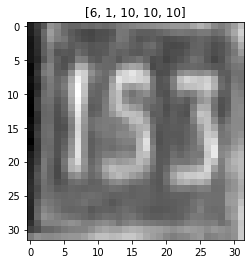

In [149]:
plt.imshow(x_train_d2[4], cmap=plt.cm.binary)
plt.title(
    (flattened_y_test[4]))